In [ ]:
import pandas as pd
import numpy as np
import json

In [2]:
raw_df = pd.read_csv('first_query_clustered.csv')
embedding_path =  'wildchat_embeddings.jsonl' 
embeddings = []
with open(embedding_path, 'r') as f:
    for line in f:
        embeddings.append(json.loads(line))

embeddings = np.array(embeddings)


In [3]:
raw_df.head()

,conversation_hash,hashed_ip,timestamp,first_user_query,device_type,cluster,typid_label,typid_score,politeguard_label,politeguard_score,formality_label,formality_score
0,c9ec5b440fbdd2a269333dd241f32f64,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:02:53+00:00,Hey there! Are you familiar with reality shift...,windows,10,polite,0.932727,polite,0.986204,formal,0.998626
1,cf1267ca6b2f6fccc9c36652a00059a1,8133108d1c433c180c6be8302dc5a6681f2bec980190a1...,2023-04-09 00:04:52+00:00,"Old age PT hx of DM, HTN, dyslipidemia His ECG...",windows,41,polite,0.888530,neutral,0.623107,informal,0.900437
2,e98d3e74c57f9a65261df393d9124ac2,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:06:49+00:00,Hey there! Are you familiar with reality shift...,windows,10,polite,0.936191,polite,0.987203,formal,0.998625
3,2e8fd255aab694b07a0be8d83cb53a7b,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:08:41+00:00,Hey there! Are you familiar with reality shift...,windows,49,polite,0.929415,polite,0.987390,formal,0.998623
4,59c72510f3143025f94f75b883b026bd,dbf18c49cf217bc344a40b187ed35c3219f994b1d3b2d0...,2023-04-09 00:10:00+00:00,i wanna you to write me terms & conditions and...,windows,2,polite,0.922587,polite,0.955610,informal,0.997220


In [4]:
# drop duplicated "conversation_hash"
# Also drop duplicates in the embeddings list based on conversation_hash
# First create a dictionary to map conversation_hash to index
conversation_hash_to_index = {}
unique_embeddings = []

for i, item in enumerate(embeddings):
    conv_hash = item['conversation_hash']
    if conv_hash not in conversation_hash_to_index:
        conversation_hash_to_index[conv_hash] = len(unique_embeddings)
        unique_embeddings.append(item)

# Replace the original embeddings with the deduplicated list
embeddings = unique_embeddings
print(f"Number of embeddings after removing duplicates: {len(embeddings)}")


Number of embeddings after removing duplicates: 474405


In [8]:
from datasets import load_dataset
ds = load_dataset("allenai/WildChat-1M", split="train")

In [31]:
# Option 1: Using numpy.unique (recommended for efficiency)
# Extract the 'hashed_ip' column as a NumPy array.
hashed_ips = np.array(ds['hashed_ip'])

# Use numpy.unique to get unique IPs and their counts in one vectorized pass.
unique_ips, counts = np.unique(hashed_ips, return_counts=True)

# Create a DataFrame from the unique IPs and their counts.
ip_counts_from_ds = pd.DataFrame({'hashed_ip': unique_ips, 'message_count': counts})

# Sort by message_count in descending order.
ip_counts_from_ds = ip_counts_from_ds.sort_values('message_count', ascending=False).reset_index(drop=True)

# Display the first few rows.
print("IP counts from the loaded dataset (using numpy.unique):")
print(ip_counts_from_ds.head())

IP counts from the loaded dataset (using numpy.unique):
                                           hashed_ip  message_count
0  25fe0280393351ba0fcf578cad274f8f2ca29975caa299...           6528
1  2a28eab6a25a22abbe8a2de22f61e06101936bad97e1b8...           5870
2  3e7ae36b9ca739b0e16876727814a0e8470c8496aab833...           5766
3  a5146fac10d0a974d79af83042eed65659396495d29396...           4519
4  1a9716c8c12582dba11f8fc121967013d445ef324af98c...           3571


In [32]:
raw_df.columns

Index(['conversation_hash', 'hashed_ip', 'timestamp', 'first_user_query',
       'device_type', 'cluster', 'typid_label', 'typid_score',
       'politeguard_label', 'politeguard_score', 'formality_label',
       'formality_score'],
      dtype='object')

### Add extra columns

In [33]:
# Merge the ip_counts data with raw_df
raw_df = raw_df.merge(ip_counts_from_ds, on='hashed_ip', how='left')

# Create the boolean columns
raw_df['is_ip_message_gt_20'] = raw_df['message_count'] > 20
raw_df['is_ip_message_gt_100'] = raw_df['message_count'] > 100

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Set the style for a professional publication look
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with subplots - make it larger for publication
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Set a modern, publication-friendly font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

# Define a more subdued, research-appropriate color palette
research_colors = sns.light_palette("seagreen", n_colors=4, reverse=True) 
sns.set_palette(sns.color_palette(research_colors))

# Figure 1: Histogram
plt.figure(figsize=(10, 8))
ax1 = plt.gca()

# Create the histogram with subdued colors
sns.histplot(data=ip_counts_from_ds, x='message_count', bins=50, 
             color=research_colors[0], alpha=0.8, ax=ax1)

# Enhance axis labels and title with larger fonts
ax1.set_title('Distribution of Messages per IP Address', fontsize=22, fontweight='bold')
ax1.set_xlabel('Number of Messages per IP', fontsize=18)
ax1.set_ylabel('Count of IP Addresses (log scale)', fontsize=18)
ax1.set_yscale('log')  # Log scale to better show the distribution
ax1.tick_params(axis='both', which='major', labelsize=14)

# Add a text annotation explaining the key insight
ax1.text(0.1, 0.95, 'Most IP addresses send very few messages\nwhile a small number of IPs contribute\nthe majority of traffic', 
         transform=ax1.transAxes, fontsize=16, va='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7, y=1.05))

plt.tight_layout()
# plt.savefig('ip_message_histogram.png', dpi=300, bbox_inches='tight')
# plt.savefig('ip_message_histogram.pdf', format='pdf', bbox_inches='tight')

# Figure 2: Pie Chart (separate figure)
plt.figure(figsize=(14, 10))
ax2 = plt.gca()

# Calculate data for pie chart
total_messages = ip_counts_from_ds['message_count'].sum()
total_ips = len(ip_counts_from_ds)

# Define user groups including the single-message category
single_users = ip_counts_from_ds[ip_counts_from_ds['message_count'] == 1]
light_users = ip_counts_from_ds[(ip_counts_from_ds['message_count'] > 1) & 
                               (ip_counts_from_ds['message_count'] <= 20)]
medium_users = ip_counts_from_ds[(ip_counts_from_ds['message_count'] > 20) & 
                                (ip_counts_from_ds['message_count'] <= 100)]
heavy_users = ip_counts_from_ds[ip_counts_from_ds['message_count'] > 100]

# Calculate message percentages
single_msgs_pct = single_users['message_count'].sum() / total_messages * 100
light_msgs_pct = light_users['message_count'].sum() / total_messages * 100
medium_msgs_pct = medium_users['message_count'].sum() / total_messages * 100
heavy_msgs_pct = heavy_users['message_count'].sum() / total_messages * 100

# Create pie chart with improved aesthetics and subdued colors
sizes = [heavy_msgs_pct, medium_msgs_pct, light_msgs_pct, single_msgs_pct]
labels = [
    f'Heavy (>100 msgs)\n{len(heavy_users)} IPs ({len(heavy_users)/total_ips*100:.1f}%)',
    f'Medium (21-100 msgs)\n{len(medium_users)} IPs ({len(medium_users)/total_ips*100:.1f}%)',
    f'Light (2-20 msgs)\n{len(light_users)} IPs ({len(light_users)/total_ips*100:.1f}%)',
    f'Single message \n{len(single_users)} IPs ({len(single_users)/total_ips*100:.1f}%)'
]

# Create mild exploded pie chart
explode = (0.05, 0.02, 0, 0)  # Subtle explode effect

wedges, texts, autotexts = ax2.pie(
    sizes, 
    labels=None,  # We'll add custom legend instead
    explode=explode,
    colors=research_colors, 
    autopct='%1.1f%%', 
    startangle=90,
    shadow=False,
    textprops={'fontsize': 14}
)

# Enhance the appearance of percentage labels
for autotext in autotexts:
    autotext.set_fontweight('bold')
    # Keep text color black for better readability on lighter colors
    

# Center the title properly with more space
plt.title('Message Volume Distribution by Unique IP Addresses', 
          fontsize=22, 
          fontweight='bold',
          x=0.6)  

# Position legend more elegantly
plt.legend(
    wedges, 
    labels,
    title="IP Categories",
    loc="upper right",  # Position in upper right
    bbox_to_anchor=(1.2, 0.95),  # Fine-tune position
    fontsize=14,
    title_fontsize=16
)

# Reposition the insight annotation to be under the pie chart
plt.figtext(0.5, 0.05,  # x=0.5 centers it, y=0.05 puts it near bottom
            "Insight: A small fraction of IPs (~3%) generates\nthe majority (~50%) of message traffic",
            ha='center', va='center', fontsize=16,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white', alpha=0.7))

plt.subplots_adjust(bottom=0.2)  # Make room at bottom for annotation
# Adjust layout to balance everything
plt.tight_layout()#(rect=[0, 0.05, 1, 0.95])  # Leave space at top and bottom

# plt.tight_layout()
# plt.savefig('ip_message_piechart.png', dpi=300, bbox_inches='tight')
# plt.savefig('ip_message_piechart.pdf', format='pdf', bbox_inches='tight')

# Display the plots (in a notebook this would show both)
plt.show()

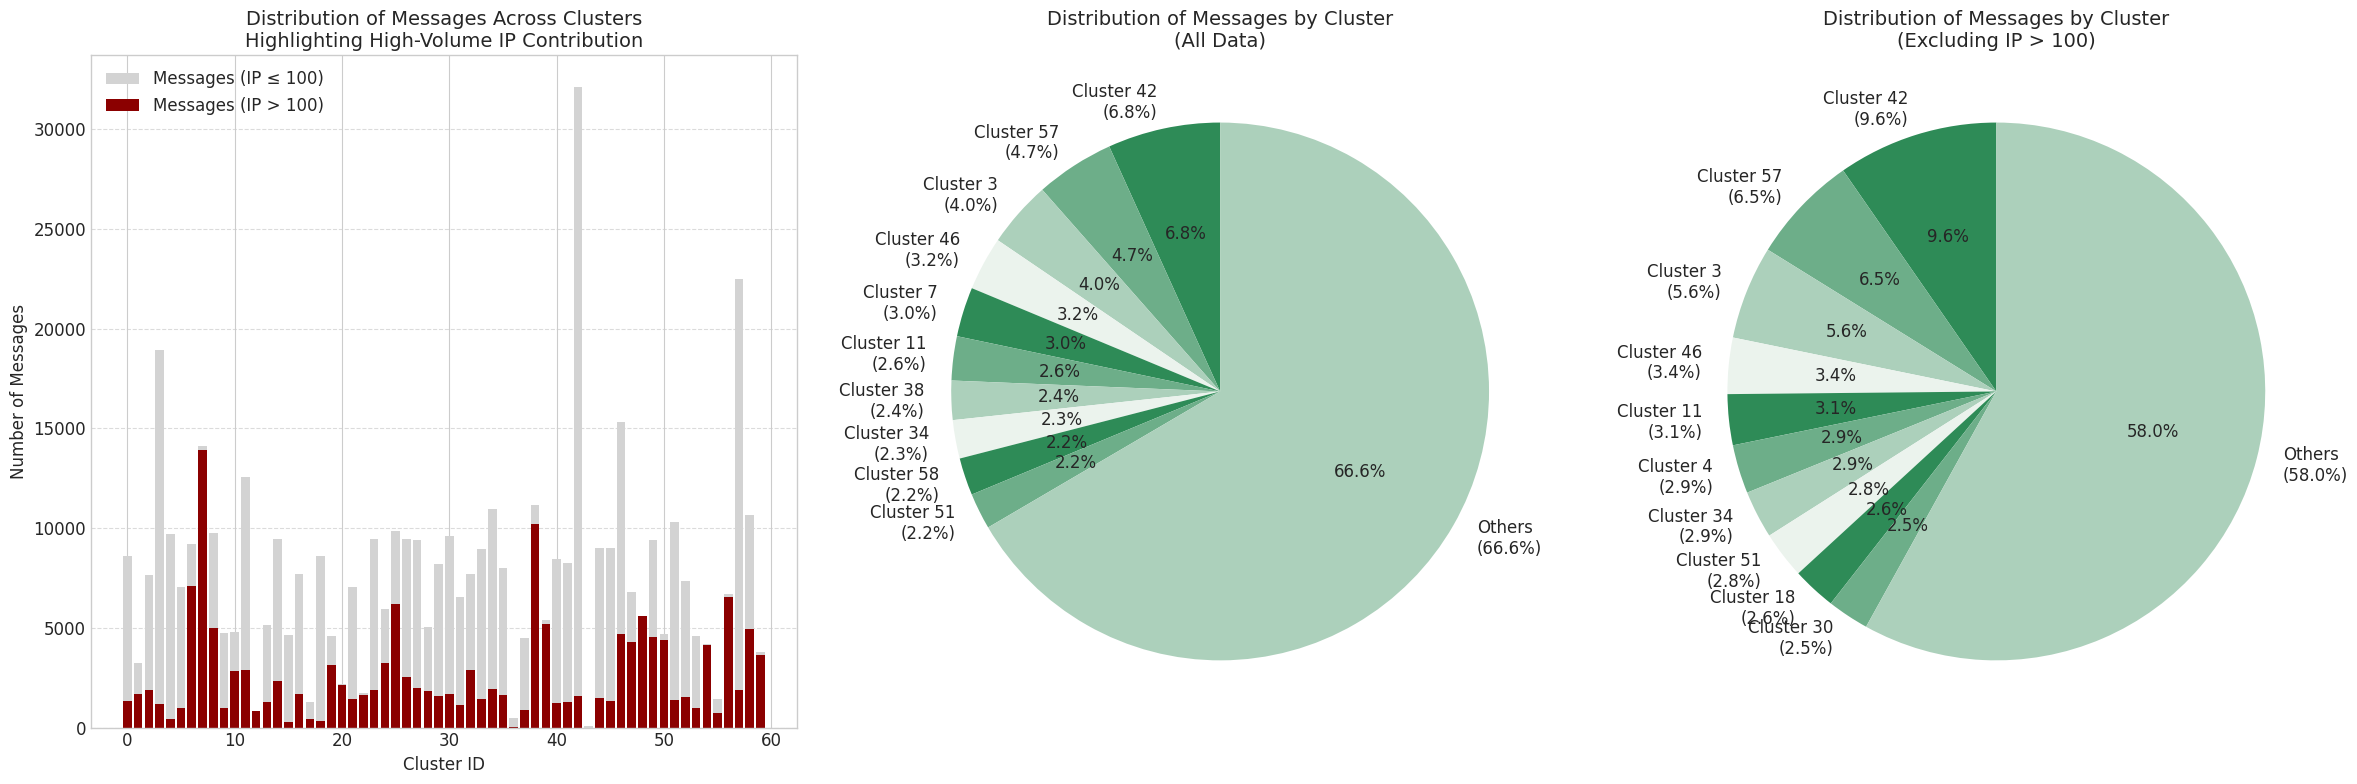


Cluster Distribution Summary:
Total number of messages: 474,405
Messages from high-volume IPs (>100): 158,332 (33.4%)

Top 5 clusters by message count:
Cluster 42: 32,091 messages total, 1,593 from high-volume IPs (5.0%)
Cluster 57: 22,467 messages total, 1,877 from high-volume IPs (8.4%)
Cluster 3: 18,938 messages total, 1,177 from high-volume IPs (6.2%)
Cluster 46: 15,341 messages total, 4,671 from high-volume IPs (30.4%)
Cluster 7: 14,129 messages total, 13,896 from high-volume IPs (98.4%)


In [66]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# 1. Cluster Distribution Analysis
cluster_counts = raw_df['cluster'].value_counts().sort_index()
cluster_counts_high_ip = raw_df[raw_df['is_ip_message_gt_100']]['cluster'].value_counts().sort_index()

# Create the stacked bar plot
bar_width = 0.8
bars = ax1.bar(cluster_counts.index, cluster_counts.values, bar_width, 
               label='Messages (IP ≤ 100)', color='lightgray')
bars_high = ax1.bar(cluster_counts_high_ip.index, cluster_counts_high_ip.values, bar_width,
                    label='Messages (IP > 100)', color='darkred')

ax1.set_title('Distribution of Messages Across Clusters\nHighlighting High-Volume IP Contribution', fontsize=14)
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Number of Messages', fontsize=12)
ax1.legend()

# Add grid for better readability
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# 2. Pie Chart - All Data
cluster_percentages = (cluster_counts / len(raw_df) * 100)
top_clusters = cluster_percentages.nlargest(10)
other_pct = cluster_percentages[~cluster_percentages.index.isin(top_clusters.index)].sum()
sizes = np.append(top_clusters.values, other_pct)
labels = [f'Cluster {i}\n({v:.1f}%)' for i, v in zip(top_clusters.index, top_clusters.values)]
labels.append(f'Others\n({other_pct:.1f}%)')

ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Messages by Cluster\n(All Data)', fontsize=14)

# 3. Pie Chart - Excluding High-Volume IPs
filtered_df = raw_df[~raw_df['is_ip_message_gt_100']]
filtered_cluster_counts = filtered_df['cluster'].value_counts().sort_index()
filtered_percentages = (filtered_cluster_counts / len(filtered_df) * 100)
filtered_top_clusters = filtered_percentages.nlargest(10)
filtered_other_pct = filtered_percentages[~filtered_percentages.index.isin(filtered_top_clusters.index)].sum()
filtered_sizes = np.append(filtered_top_clusters.values, filtered_other_pct)
filtered_labels = [f'Cluster {i}\n({v:.1f}%)' for i, v in zip(filtered_top_clusters.index, filtered_top_clusters.values)]
filtered_labels.append(f'Others\n({filtered_other_pct:.1f}%)')

ax3.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=90)
ax3.set_title('Distribution of Messages by Cluster\n(Excluding IP > 100)', fontsize=14)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nCluster Distribution Summary:")
print(f"Total number of messages: {len(raw_df):,}")
print(f"Messages from high-volume IPs (>100): {len(raw_df[raw_df['is_ip_message_gt_100']]):,} "
      f"({len(raw_df[raw_df['is_ip_message_gt_100']]) / len(raw_df) * 100:.1f}%)")
print("\nTop 5 clusters by message count:")
for cluster, count in cluster_counts.nlargest(5).items():
    high_vol_count = cluster_counts_high_ip.get(cluster, 0)
    print(f"Cluster {cluster}: {count:,} messages total, {high_vol_count:,} from high-volume IPs "
          f"({high_vol_count/count*100:.1f}%)")

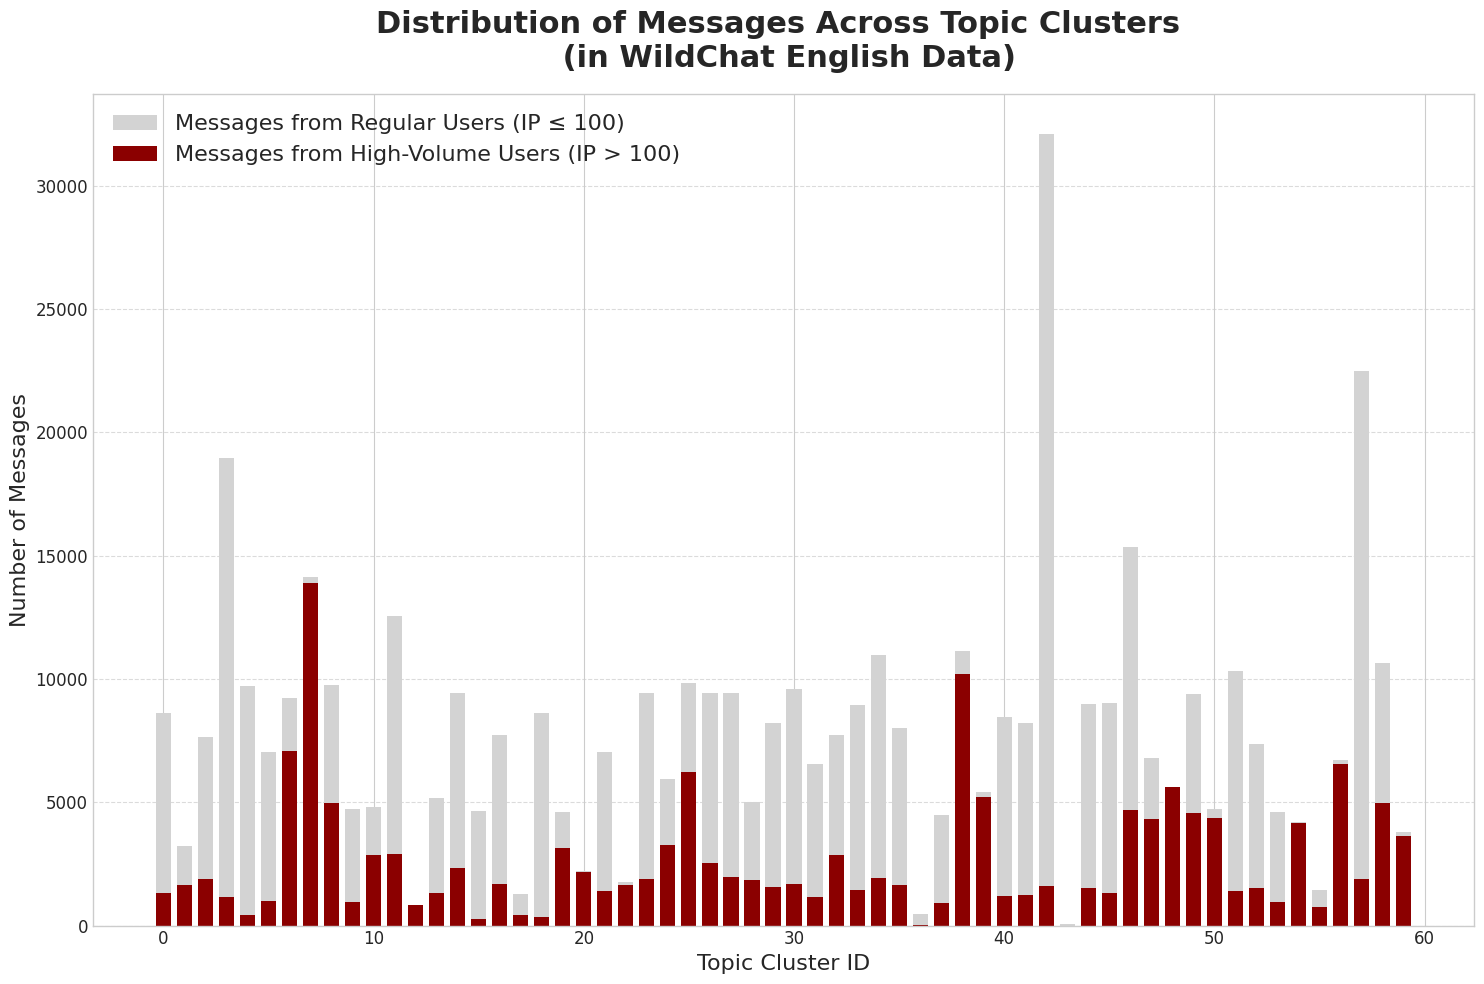


Cluster Distribution Summary:
Total number of clusters: 60
Average messages per cluster: 7906.8
Median messages per cluster: 7716.0

Top 5 largest clusters:
Cluster 42: 32,091 total messages
    - 1,593 from high-volume IPs (5.0%)
    - 30,498 from regular IPs (95.0%)
Cluster 57: 22,467 total messages
    - 1,877 from high-volume IPs (8.4%)
    - 20,590 from regular IPs (91.6%)
Cluster 3: 18,938 total messages
    - 1,177 from high-volume IPs (6.2%)
    - 17,761 from regular IPs (93.8%)
Cluster 46: 15,341 total messages
    - 4,671 from high-volume IPs (30.4%)
    - 10,670 from regular IPs (69.6%)
Cluster 7: 14,129 total messages
    - 13,896 from high-volume IPs (98.4%)
    - 233 from regular IPs (1.6%)


In [91]:
# Create a larger figure for just the histogram
plt.figure(figsize=(15, 10))

# Get the data
cluster_counts = raw_df['cluster'].value_counts().sort_index()
cluster_counts_high_ip = raw_df[raw_df['is_ip_message_gt_100']]['cluster'].value_counts().sort_index()

# Create the stacked bar plot
bar_width = 0.72
bars = plt.bar(cluster_counts.index, cluster_counts.values, bar_width, 
               label='Messages from Regular Users (IP ≤ 100)', color='lightgray')
bars_high = plt.bar(cluster_counts_high_ip.index, cluster_counts_high_ip.values, bar_width,
                    label='Messages from High-Volume Users (IP > 100)', color='darkred')

# Customize the plot
plt.title('Distribution of Messages Across Topic Clusters \n (in WildChat English Data)', 
          fontsize=22, pad=20, fontweight='bold')
plt.xlabel('Topic Cluster ID', fontsize=16)
plt.ylabel('Number of Messages', fontsize=16)
plt.legend(fontsize=16)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics for the distribution
print("\nCluster Distribution Summary:")
print(f"Total number of clusters: {len(cluster_counts)}")
print(f"Average messages per cluster: {cluster_counts.mean():.1f}")
print(f"Median messages per cluster: {cluster_counts.median():.1f}")
print("\nTop 5 largest clusters:")
for cluster, count in cluster_counts.nlargest(5).items():
    high_vol_count = cluster_counts_high_ip.get(cluster, 0)
    print(f"Cluster {cluster}: {count:,} total messages")
    print(f"    - {high_vol_count:,} from high-volume IPs ({high_vol_count/count*100:.1f}%)")
    print(f"    - {count-high_vol_count:,} from regular IPs ({(count-high_vol_count)/count*100:.1f}%)")

Cluster result

In [81]:
cluster_info_df = pd.read_csv("cluster_summary_results.csv")

In [87]:
cluster_info_df.head()

,cluster,total_messages,unique_ips,avg_ip_message_count,median_ip_message_count,std_ip_message_count,perc_msg_above_20,perc_msg_above_100,coherence,cluster_typid_impolite,cluster_politeguard_impolite,cluster_formality_informal,device_mac_percent,device_mobile_percent,device_other_percent,device_unknown_percent,device_windows_percent
0,0,8610,5022,83.765621,9.0,337.469410,37.549361,15.400697,0.097492,24.355401,6.144019,50.940767,11.835075,12.659698,12.125436,0.998839,62.380952
1,1,3229,480,752.517498,116.0,989.655170,76.277485,51.440074,0.313439,55.744813,4.118922,2.663363,34.871477,4.893156,1.052958,0.030969,59.151440
2,2,7632,3929,171.955451,14.0,504.345714,44.025157,24.764151,0.155384,40.749476,9.512579,29.703878,8.844340,17.937631,6.001048,0.170335,67.046646
3,3,18938,7142,39.065794,11.0,114.945673,34.729116,6.215017,0.871547,0.021122,0.000000,0.005280,18.671454,10.967367,0.227057,0.000000,70.134122
4,4,9694,8096,25.704044,2.0,172.513480,14.854549,4.559521,0.718415,75.293996,1.794925,70.311533,10.552919,19.125232,6.529812,0.453889,63.338147


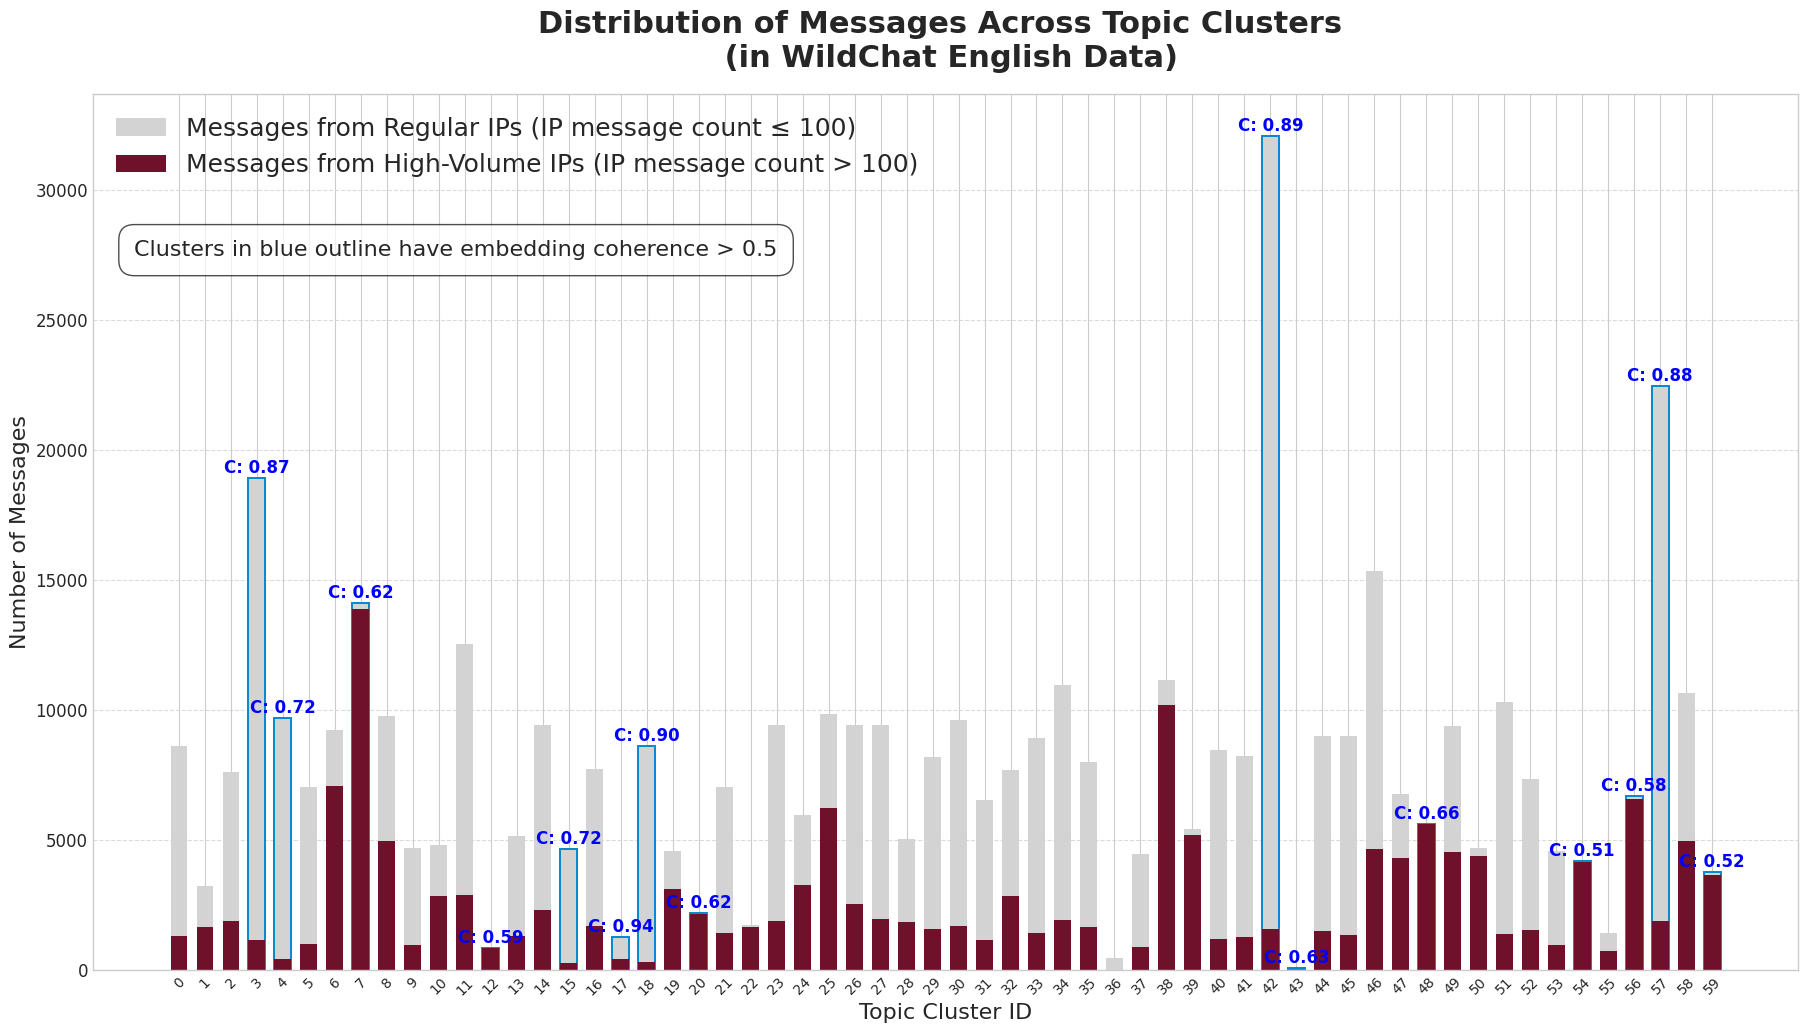

In [172]:
# Create a larger figure for just the histogram
plt.figure(figsize=(22, 12))  # Made it a bit wider to accommodate all indices

# Get the data
cluster_counts = raw_df['cluster'].value_counts().sort_index()
cluster_counts_high_ip = raw_df[raw_df['is_ip_message_gt_100']]['cluster'].value_counts().sort_index()

# Create the stacked bar plot
bar_width = 0.65
bars = plt.bar(cluster_counts.index, cluster_counts.values, bar_width, 
               label='Messages from Regular IPs (IP message count ≤ 100)', color='lightgray')
bars_high = plt.bar(cluster_counts_high_ip.index, cluster_counts_high_ip.values, bar_width,
                    label='Messages from High-Volume IPs (IP message count > 100)', color='#6f112b')

# Customize the plot
plt.title('Distribution of Messages Across Topic Clusters \n (in WildChat English Data)', 
          fontsize=22, pad=20, fontweight='bold')
plt.xlabel('Topic Cluster ID', fontsize=16)
plt.ylabel('Number of Messages', fontsize=16)
plt.legend(fontsize=18)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show all indices on x-axis
plt.xticks(cluster_counts.index, fontsize=10, rotation=45)  # Show all cluster indices with rotation

# Highlight special clusters based on coherence threshold
coherence_threshold = 0.5  # Adjust this to your desired threshold
special_clusters = cluster_info_sorted[cluster_info_sorted['coherence'] > coherence_threshold]['cluster']

# Add annotations for special clusters
for cluster in special_clusters:
    if cluster in cluster_counts.index:
        idx = list(cluster_counts.index).index(cluster)
        bar = bars[idx]
        coherence_value = cluster_info_sorted[cluster_info_sorted['cluster'] == cluster]['coherence'].values[0]
        
        # Make special cluster bars stand out with an outline
        bar.set_edgecolor('#0288d1')
        bar.set_linewidth(1.4)
        # Add a label above the bar
        height = cluster_counts.iloc[idx]
        plt.text(cluster, height + 50, f"C: {coherence_value:.2f}", 
                 ha='center', va='bottom', fontweight='bold', color='blue')

# Add a note about special clusters

# Reposition the insight annotation to be under the pie chart
plt.figtext(0.29, 0.75,  # x=0.5 centers it,
            f"Clusters in blue outline have embedding coherence > {coherence_threshold}",
            ha='center', va='center', fontsize=16,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white', alpha=0.7))
# plt.figtext(0.5, 0.01, f"Clusters in blue have coherence > {coherence_threshold}", 
#             ha='left', fontsize=12, fontstyle='italic')

# Adjust layout with more bottom space for the note
plt.subplots_adjust(bottom=0.15)

# Show the plot

plt.show()

In [130]:
cluster_themes = {
    0: 'Coding & Programming Assistance',
    1: 'Original Fiction & Roleplay',
    2: 'Professional Business Communication',
    3: 'Structured Prompt Generation',
    4: 'Social Script (Greetings)',
    5: 'Marketing, SEO, and Ideation',
    6: 'Fanfiction & Crossover',
    7: 'Fanfiction & Crossover',
    8: 'Original Fiction & Fetish Mix',
    9: 'Prompt Injection & Meta-hacks',
    10: 'Guided Explicit Content Generation',
    11: 'Educational Q&A and Study Assistance',
    12: 'Fetish Comedy Fanfic',
    13: 'Non-English Localized Queries',
    14: 'Structured Creative Writing & Role-Play',
    15: 'Marketing, SEO, and Ideation',
    16: 'Educational Q&A and Study Assistance',
    17: 'Federated Multi-Agent Control',
    18: 'Structured Prompt Generation',
    19: 'Fanfiction (Anime/Game Crossover)',
    20: 'Fetish / Scriptwriting',
    21: 'Educational Q&A and Study Assistance',
    22: 'Fanfiction (Game Fanfic)',
    23: 'Coding & Programming Assistance',
    24: 'Original World-Building + Fetish',
    25: 'Fanfiction & Original Hybrid',
    26: 'Language Translation & Grammar',
    27: 'Educational Q&A and Study Assistance',
    28: 'Music/Pop-Culture Creative',
    29: 'Poetry & Writing Advice',
    30: 'Context/Evaluation Setup',
    31: 'High-Constraint Output Formatting',
    32: 'Game Design & Lore',
    33: 'Professional & Business Communication',
    34: 'Specialized Expert Consultation',
    35: 'Specialized Expert Consultation',
    36: 'Interactive Roleplay',
    37: 'Non-English Localized Queries with "Code-switching"',
    38: 'Fanfic Fetish (Pregnancy)',
    39: 'Original Scripted Series',
    40: 'IT Troubleshooting and Technical Support',
    41: 'Specialized Expert Consultation',
    42: 'Structured Prompt Generation',
    43: 'General Knowledge and List Requests',
    44: 'Professional & Business Communication',
    45: 'General Knowledge and List Requests',
    46: 'IT Troubleshooting and Technical Support',
    47: 'Media Content Creation',
    48: 'Fanfiction (Anime Game)',
    49: 'Transformation Erotica',
    50: 'Niche (Sports Fantasy)',
    51: 'General Knowledge and List Requests',
    52: 'Coding & Programming Assistance',
    53: 'General Knowledge and List Requests',
    54: 'Fetish Comedy Fanfic',
    55: 'Structured Creative Writing & Role-Play',
    56: 'Federated Agent Response Generation',
    57: 'Structured Prompt Generation',
    58: 'Historical & Mythological Inquiry/Creation',
    59: 'Guided Roleplay Scriptwriting'
}

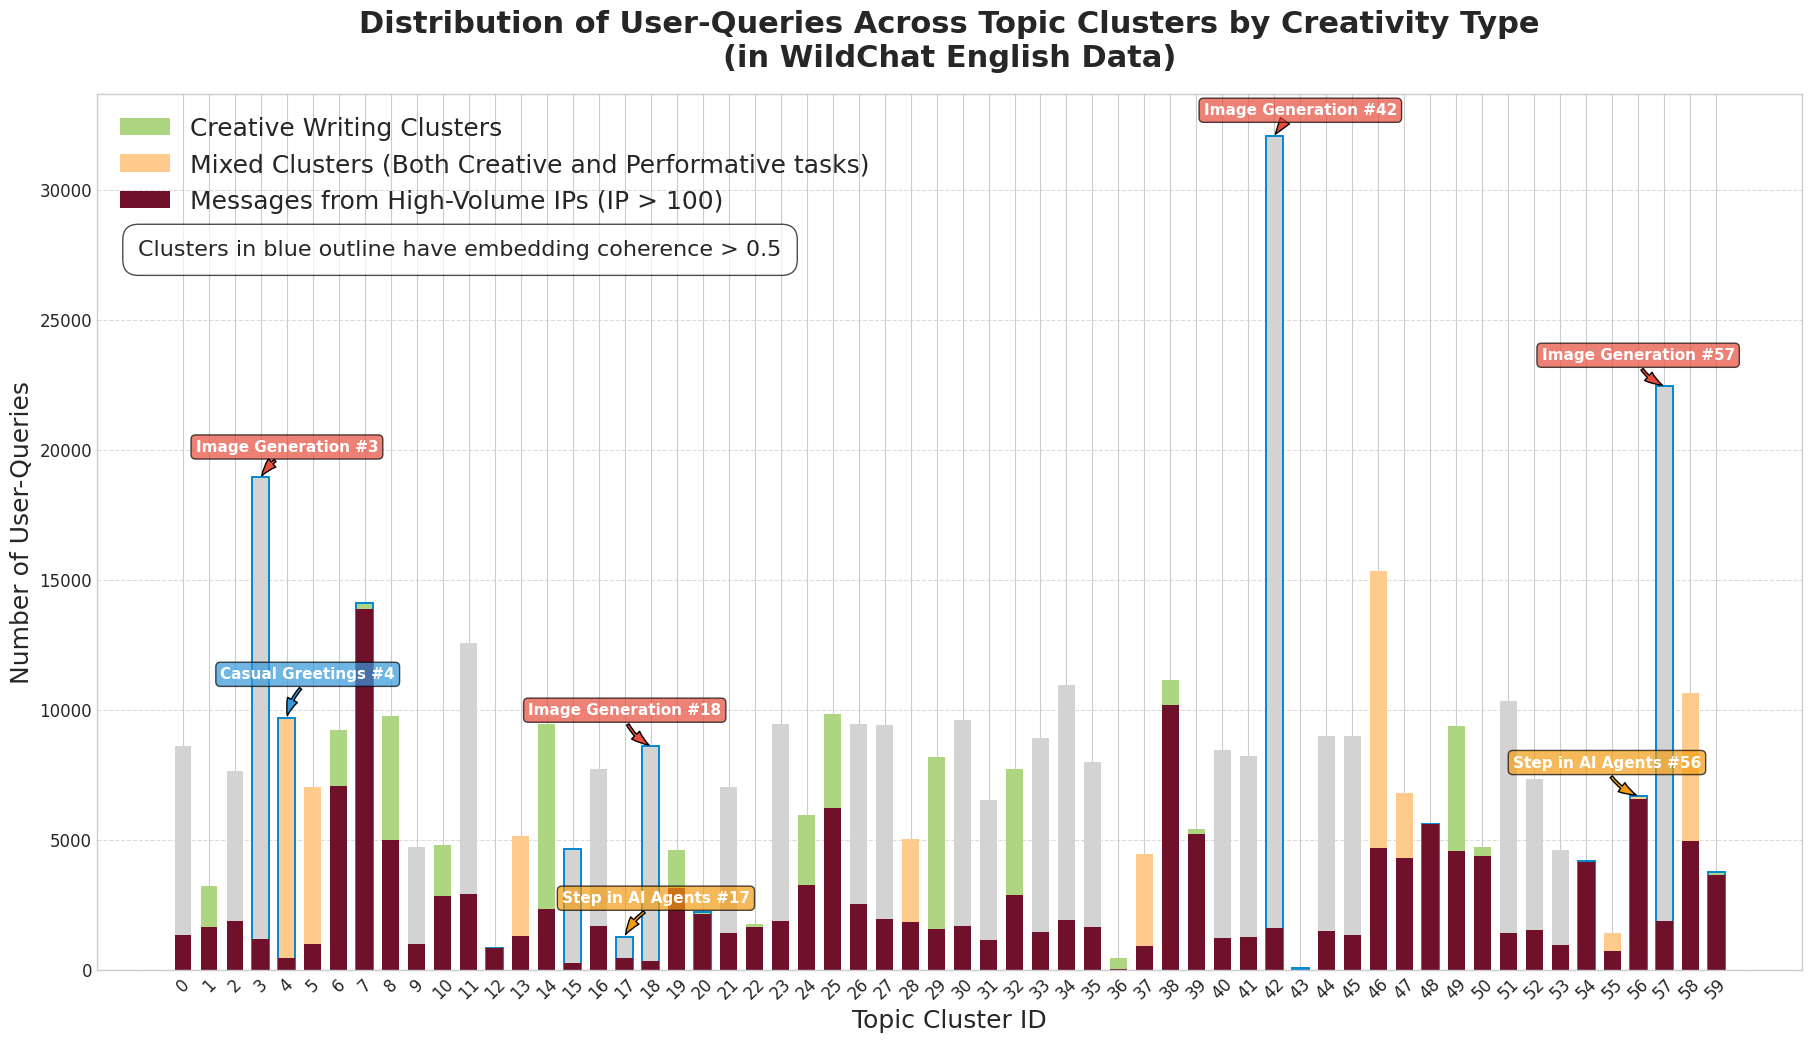

In [178]:
# Create a larger figure for just the histogram
plt.figure(figsize=(22, 12))

# Get the data
cluster_counts = raw_df['cluster'].value_counts().sort_index()
cluster_counts_high_ip = raw_df[raw_df['is_ip_message_gt_100']]['cluster'].value_counts().sort_index()

# Create a mapping of clusters to their types based on the provided table
cluster_types = {
    0: 'Performative', 1: 'Creative', 2: 'Performative', 3: 'Performative',
    4: 'Both', 5: 'Both', 6: 'Creative', 7: 'Creative',
    8: 'Creative', 9: 'Performative', 10: 'Creative', 11: 'Performative',
    12: 'Creative', 13: 'Both', 14: 'Creative', 15: 'Performative',
    16: 'Performative', 17: 'Performative', 18: 'Performative', 19: 'Creative',
    20: 'Creative', 21: 'Performative', 22: 'Creative', 23: 'Performative',
    24: 'Creative', 25: 'Creative', 26: 'Performative', 27: 'Performative',
    28: 'Both', 29: 'Creative', 30: 'Performative', 31: 'Performative',
    32: 'Creative', 33: 'Performative', 34: 'Performative', 35: 'Performative',
    36: 'Creative', 37: 'Both', 38: 'Creative', 39: 'Creative',
    40: 'Performative', 41: 'Performative', 42: 'Performative', 43: 'Performative',
    44: 'Performative', 45: 'Performative', 46: 'Both', 47: 'Both',
    48: 'Creative', 49: 'Creative', 50: 'Creative', 51: 'Performative',
    52: 'Performative', 53: 'Performative', 54: 'Creative', 55: 'Both',
    56: 'Both', 57: 'Performative', 58: 'Both', 59: 'Creative'
}

# Define colors for each type

# Define contrasting colors for each type
type_colors = {
    'Creative': '#aed581',  # Purple
    'Performative': '#d3d3d3',  # Green #grey = #d3d3d3
    'Both': '#ffcb8c'  # Orange/Amber for "Both" category
}

# Create the stacked bar plot with colors based on cluster type
bar_width = 0.65
bars = []

for i, cluster in enumerate(cluster_counts.index):
    cluster_type = cluster_types.get(cluster, 'Performative')  # Default to Performative if not found
    bar_color = type_colors[cluster_type]
    
    # Base bar (regular users)
    bar = plt.bar(cluster, cluster_counts.iloc[i], bar_width, 
                 color=bar_color)
    
    # High IP users portion
    high_ip_value = cluster_counts_high_ip.get(cluster, 0)
    plt.bar(cluster, high_ip_value, bar_width,
            color='#6f112b')
    
    bars.append(bar[0])

# Customize the plot
plt.title('Distribution of User-Queries Across Topic Clusters by Creativity Type\n(in WildChat English Data)', 
          fontsize=22, pad=20, fontweight='bold')
plt.xlabel('Topic Cluster ID', fontsize=18)
plt.ylabel('Number of User-Queries', fontsize=18)

# Create custom legend
creative_patch = plt.Rectangle((0, 0), 1, 1, fc=type_colors['Creative'], edgecolor='none')
#performative_patch = plt.Rectangle((0, 0), 1, 1, fc=type_colors['Performative'], edgecolor='none')
both_patch = plt.Rectangle((0, 0), 1, 1, fc=type_colors['Both'], edgecolor='none')
high_ip_patch = plt.Rectangle((0, 0), 1, 1, fc='#6f112b', edgecolor='none')
#performative_patch,'Performative Clusters',
plt.legend([creative_patch,  both_patch, high_ip_patch],
           ['Creative Writing Clusters',  'Mixed Clusters (Both Creative and Performative tasks)', 'Messages from High-Volume IPs (IP > 100)'],
           fontsize=18, loc='upper left')

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show all indices on x-axis
plt.xticks(cluster_counts.index, fontsize=12, rotation=45)


# Highlight special clusters based on coherence threshold
coherence_threshold = 0.5  # Adjust this to your desired threshold
special_clusters = cluster_info_sorted[cluster_info_sorted['coherence'] > coherence_threshold]['cluster']

# Add annotations for special clusters
for cluster in special_clusters:
    if cluster in cluster_counts.index:
        idx = list(cluster_counts.index).index(cluster)
        bar = bars[idx]
        coherence_value = cluster_info_sorted[cluster_info_sorted['cluster'] == cluster]['coherence'].values[0]
        
        # Make special cluster bars stand out with an outline
        bar.set_edgecolor('#0288d1')
        bar.set_linewidth(1.4)
        # # Add a label above the bar
        # height = cluster_counts.iloc[idx]
        # plt.text(cluster, height + 50, f"C: {coherence_value:.2f}", 
        #          ha='center', va='bottom', fontweight='bold', color='blue')


# Create lists of specific clusters to annotate based on your requirements
image_gen_clusters = [3, 18, 42, 57]  # Clusters used for image generation prompts
greeting_cluster = [4]  # Casual greetings
dialogue_roleplay_clusters = [1, 14, 36, 55, 59]  # Clusters engaged with Dialogue & Roleplay
fictional_storytelling_clusters = [6, 7, 8, 19, 22, 25, 32, 38, 39, 48, 49, 50]  # Fictional storytelling

# Define key clusters to annotate with custom positions
annotations = {
    'Image Generation': {
        'clusters': [3, 18, 42, 57], 
        'color': '#e74c3c',
        'positions': {  # Custom x,y offsets for each cluster
            3: (1.0, 1000),
            18: (-1.0, 1200),
            42: (1.0, 800),
            57: (-1.0, 1000)
        }
    },
    'Casual Greetings': {
        'clusters': [4], 
        'color': '#3498db',
        'positions': {4: (0.8, 1500)}
    },
    'Step in AI Agents': {
        'clusters': [17, 56], 
        'color': '#f39c12',
        'positions': {
            17: (1.2, 1300),
            56: (-1.2, 1100)
        }
    }
}

# Add annotations with custom positioning
for category, params in annotations.items():
    for cluster in params['clusters']:
        if cluster in cluster_counts.index:
            height = cluster_counts.get(cluster, 0)
            
            # Get the custom position for this specific cluster
            x_offset, y_offset = params['positions'].get(cluster, (1.0, 1000))
            
            # Add a diagonal arrow pointing to the bar with custom position
            plt.annotate(
                f"{category} #{cluster}",  # Include cluster number in label
                xy=(cluster, height),  # Where the arrow points to
                xytext=(cluster + x_offset, height + y_offset),  # Where the text is
                arrowprops=dict(
                    facecolor=params['color'], 
                    shrink=0.05, 
                    width=2, 
                    headwidth=8,
                    # Add an id for easy adjustment later
                    connectionstyle=f"arc3,rad=0.2"  # Curved arrow for better visibility
                ),
                fontsize=11,
                fontweight='bold',
                bbox=dict(
                    boxstyle="round,pad=0.3", 
                    facecolor=params['color'], 
                    alpha=0.7
                    # # Add an id attribute for the box
                    # boxstyle="round,pad=0.3"
                ),
                color='white',
                ha='center',
                # Add a custom annotation id for easy reference in adjustments
                annotation_clip=False  # Allow annotations outside the plot area
            )

plt.figtext(0.29, 0.75,  # x=0.5 centers it,
            f"Clusters in blue outline have embedding coherence > {coherence_threshold}",
            ha='center', va='center', fontsize=16,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white', alpha=0.7))
# Adjust layout
plt.subplots_adjust(bottom=0.15)

plt.show()